## Libraries

---



In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
import keras.layers as L
from keras.models import Model
import glob
import cv2

## Building model

---



In [ ]:
def encode(Xip,f,input=True):
    if input==False:
      Xip = L.MaxPool2D((2, 2), strides=2)(Xip)
    X = L.Conv2D(f, (3, 3), padding='same')(Xip)
    X = L.BatchNormalization()(X)
    X = L.LeakyReLU(alpha=0.2)(X)    
    X = L.Conv2D(f, (3, 3), padding='same')(X)
    X = L.BatchNormalization()(X)
    X = L.LeakyReLU(alpha=0.2)(X)
    return X

def decode(input,conc,f):
    X = L.Conv2DTranspose(f, (2, 2), strides=2)(input)    
    X = L.Concatenate()([conc,X])     
    X = L.Conv2D(f, (3, 3), padding='same')(X)
    X = L.BatchNormalization()(X)
    X = L.Activation('relu')(X)
    X = L.Conv2D(f, (3, 3), padding='same')(X)
    X = L.BatchNormalization()(X)
    X = L.Activation('relu')(X)
    return X

def UNet():

    Xinpt = L.Input([None, None, 1])

    X0_L = encode(Xinpt,64,)        #w,h,64  
    X1_L = encode(X0_L,128,False)   #w/2,h/2,128
    X2_L = encode(X1_L,256,False)   #w/4,h/4,256 
    X3_L = encode(X2_L,512,False)   #w/8,h/8,512
    X4_L = encode(X3_L,1024,False)  #w/16,h/16,1024
    
    X4_R = decode(X4_L,X3_L,512)    #w/8,h/8,512
    X3_R = decode(X4_R,X2_L,256)    #w/4,h/4,256
    X2_R = decode(X3_R,X1_L,128)    #w/2,h/2,128 
    X1_R = decode(X2_R,X0_L,64)     #w,h,64       
    
    X0_R = L.Conv2D(3, (1, 1), strides=1)(X1_R)     #w,h,3 
    
    model = Model(inputs=Xinpt, outputs=X0_R)
    return model

In [ ]:
model = UNet()
model.compile('adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d_38 (Conv2D)             (None, None, None,   640         ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   256        ['conv2d_38[0][0]']              
 ormalization)                  64)                                                         

## Preprocessing Data

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Resize images and save to data_resized folder
Chỉnh sửa kích thước ảnh thành 128x128 trước khi train

In [ ]:
# paths = glob.glob("/content/drive/MyDrive/Color_photo/data_raw" + "/*.jpg") # Grabbing all the image file names
# count=0
# os.chdir('/content/drive/MyDrive/Color_photo/data_resized')
# for i in paths:
#     img = cv2.imread(i)
#     img = cv2.resize(img,(128,128))
#     filename="img"+str(count)+".jpg"
#     cv2.imwrite(filename,img)
#     count+=1

### Create path lists, ramdomly pick 800 paths to train-list, 200 paths to test-list

Tạo list chứa các đường dẫn đến file ảnh, chọn ngẫu nhiên 800 ảnh cho tập train và 200 ảnh cho tập test

In [ ]:
paths = glob.glob("/content/drive/MyDrive/Color_photo/data_resized" + "/*.jpg")
print("Total files:",len(paths))
train_paths = np.random.choice(paths,1600,False) 
test_paths = np.random.choice(paths,400,False)
print("Training files:",len(train_paths))
print("Testing files:",len(test_paths))
print(train_paths[0:5])

Total files: 10000
Training files: 1600
Testing files: 400
['/content/drive/MyDrive/Color_photo/data_resized/img1168.jpg'
 '/content/drive/MyDrive/Color_photo/data_resized/img1825.jpg'
 '/content/drive/MyDrive/Color_photo/data_resized/img7768.jpg'
 '/content/drive/MyDrive/Color_photo/data_resized/img2224.jpg'
 '/content/drive/MyDrive/Color_photo/data_resized/img9184.jpg']


### Read images using cv2 and numpy
Đọc ảnh, lưu vào tập train và test dưới dạng mảng

In [ ]:
def readImg(path):
  x=[]
  for i in path:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x.append(img)
  return np.array(x)

train = readImg(train_paths)/255.
test = readImg(test_paths)/255.
train.shape,test.shape

((1600, 128, 128, 3), (400, 128, 128, 3))

(128, 128, 3)


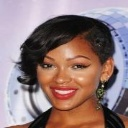

In [ ]:
from google.colab.patches import cv2_imshow
print(test[10].shape)
img = test[10]*255
imgRGB = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB)
cv2_imshow(imgRGB)
#plt.imshow(test[10],cmap="gray")

### Convert images to grayscale images
Chuyển ảnh thành màu xám 

In [ ]:
gray_train = np.mean(train, axis=-1)
gray_train = gray_train.reshape((*gray_train.shape, 1))
gray_test = np.mean(test, axis=-1)
gray_test = gray_test.reshape((*gray_test.shape, 1))
gray_train.shape,gray_test.shape

((1600, 128, 128, 1), (400, 128, 128, 1))

(128, 128, 1)


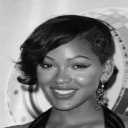

In [ ]:
from google.colab.patches import cv2_imshow
print(gray_test[10].shape)
img = gray_test[10]*255
cv2_imshow(img)
#plt.imshow(gray_train[0].reshape(128,128),cmap="gray")

## Trainning

---



### Create function to show result after each epoch
Xây dựng hàm hiển thị kết quả sau mỗi epoch

In [ ]:
def sample_batch(data, bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return idxs

def sample_images(data, gray, nrow):
    idx = sample_batch(gray, bsize=nrow)
    gray_batch = gray[idx]
    color_batch = data[idx]
    images = model.predict(gray_batch)
    if np.var(images)!=0:
        images = (images-images.min())/(images.max()-images.min())
    cnt=1
    for i in range(nrow):
        plt.subplot(nrow, 3, cnt)
        plt.imshow(color_batch[i].reshape((128,128, 3)),cmap='gray', interpolation='none')
        plt.subplot(nrow, 3, cnt+1)
        plt.imshow(gray_batch[i].reshape((128,128)),cmap='gray', interpolation='none')
        plt.subplot(nrow, 3, cnt+2)
        plt.imshow(images[i].reshape((128, 128, 3)),cmap='gray', interpolation='none')
        cnt+=3
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.show()

In [ ]:
from IPython import display
from keras.callbacks import EarlyStopping, ModelCheckpoint,CSVLogger
#set up callbacks
earlystopper = EarlyStopping(patience=5,verbose=1)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Color_photo/models/best/unet12.h5',monitor="acc",verbose=1,save_best_only=True)
logger = CSVLogger('/content/drive/MyDrive/Color_photo/models/history/training12.log', separator=',', append=True)
model.load_weights('/content/drive/MyDrive/Color_photo/models/last/unet11.h5')
for epoch in range(1, 101):
    print('Epoch:', epoch)
    model.fit(gray_train, train, batch_size=8, validation_data=(gray_test, test),callbacks=[earlystopper,checkpointer,logger])
    sample_images(test, gray_test, 5)
model.save('/content/drive/MyDrive/Color_photo/models/last/unet12.h5')


Output hidden; open in https://colab.research.google.com to view.

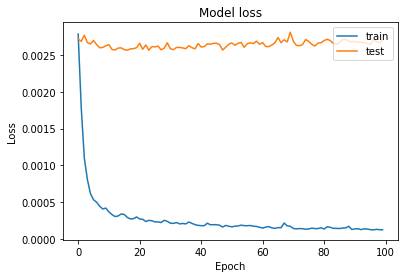

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Color_photo/models/history/training10.log')
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()